# Time series forecasting with Tesla stocks from 2010 to 2020

In [1]:
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from lstm import LstmNeuralNetwork
from processing import *

# Load the data

We load and plot Tesla stock data from 2010 to 2020.

In [2]:
tesla_data = pd.read_csv('data/TSLA_2010_2020.csv')
tesla_data = tesla_data.drop(['Date','Open','High','Low','Close'],axis = 1)
total_days = tesla_data.shape[0]
adj_close = tesla_data[['Adj Close']]
volume = tesla_data[['Volume']]
tesla_data.head()

,Adj Close,Volume
0,23.889999,18766300
1,23.830000,17187100
2,21.959999,8218800
3,19.200001,5139800
4,16.110001,6866900


We plot the adjusted close value of the tesla stock over time

<AxesSubplot:>

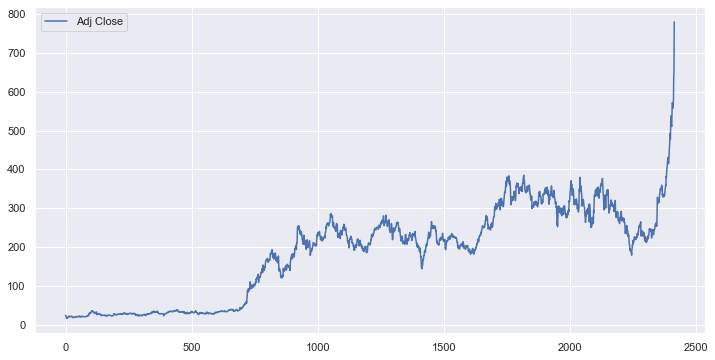

In [3]:
sns.set(rc = {'figure.figsize':(12,6)})
sns.lineplot(
    data = adj_close
)

We plot the exchange volume of the tesla stock over time

<AxesSubplot:>

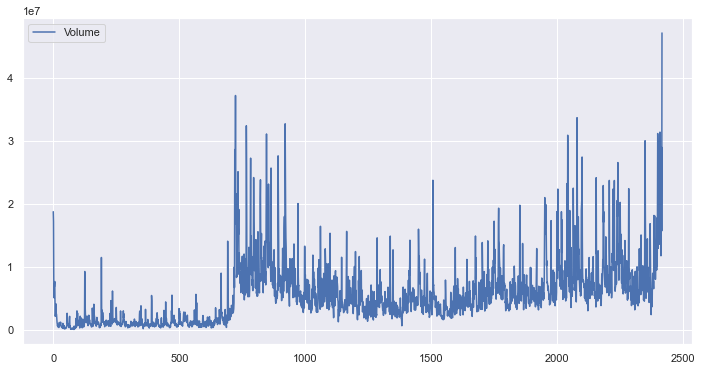

In [4]:
sns.lineplot(
    data = volume
)

# Data processing

First, we apply a 7 days moving average on the "adjusted close" time series to reduce noise (we could have performed a fast Fourier transformation to remove frequencies above a certain threshold). Then, we use a sliding window that takes the previous 15 days as features and the current day as target. We use the first 2/3 of the time series as our training set and the rest as our testing set.

In [5]:
seq_length = 15
average_size = 7
train_proportion = 2/3

In [6]:

scaler1 = MinMaxScaler(feature_range=(-1, 1))
y_raw1, X_data1, y_data1, X_train1, y_train1, X_test1, y_test1 = process_data(adj_close, seq_length, average_size, train_proportion, scaler1)

We apply a differencing on the "adjusted close" time series. This operation takes a time series $X_t$ as input and produces a new time series $dX_t$ with $dX_t = X_{t+1}-X_t$. Differencing is expected to make the "adjusted close" time series stationary. Next, we apply a 7 days moving average and a 15 days sliding window on the differenced time series.

In [7]:
scaler2 = MinMaxScaler(feature_range=(-1, 1))
y_raw2, X_data2, y_data2, X_train2, y_train2, X_test2, y_test2 = process_data_diff(adj_close, seq_length, average_size, train_proportion, scaler2)

# Model definition/training

We create two recurrent neural network model with our LstmNeuralNetwork class. The first model uses the undifferenced time series while the second model uses the differenced time series.

In [8]:
my_model1 = LstmNeuralNetwork(input_size = 1, num_layers = 2, hidden_size = 21, seq_length = seq_length)
my_model2 = LstmNeuralNetwork(input_size = 1, num_layers = 2, hidden_size = 21, seq_length = seq_length)

We train our first model with the undifferenced time series

In [18]:
num_epochs = 1000
learning_rate = 0.001
criterion = nn.MSELoss()
my_model1._train(num_epochs, learning_rate, criterion, X_train1, y_train1, X_test1, y_test1)

Epoch: 1000, Train loss: 0.00080, Test loss: 0.03340: 100%|██████████| 1001/1001 [01:51<00:00,  8.95it/s]


We train our second model with the differenced time series

In [12]:
num_epochs = 1000
learning_rate = 0.001
criterion = nn.MSELoss()    
my_model2._train(num_epochs, learning_rate, criterion, X_train2, y_train2, X_test2, y_test2)

Epoch: 1000, Train loss: 0.00090, Test loss: 0.00477: 100%|██████████| 1001/1001 [01:52<00:00,  8.91it/s]


The next line saves the models parameters for future use

In [9]:
filepath1 = 'save/model1'
filepath2 = 'save/model2'
torch.save(my_model1.state_dict(), filepath1)
torch.save(my_model2.state_dict(), filepath2)

The next line loads the saved parameters

In [9]:
filepath1 = 'save/model1'
filepath2 = 'save/model2'
my_model1.load_state_dict(torch.load(filepath1))
my_model2.load_state_dict(torch.load(filepath2))

<All keys matched successfully>

# Evaluating/Plotting the results

The naive prediction/forecasting uses the value of the last day as forecast ($\hat{y}(t+1 | t) = y(t)$). We assess the quality of our predictions by computing a mean squared error loss and a $R^2$ and comparing it with the naive prediction:

In [10]:
last_day = 2390
print('First model accuracy :')
naive_prediction1 = scaler1.inverse_transform(X_data1.numpy()[:,my_model1.seq_length-1])
my_model1.get_accuracy(X_data1, y_data1, naive_prediction1, scaler1, last_day)
print('\n')
print('Second model accuracy :')
naive_prediction2 = np.zeros(y_data2.size(0))
my_model2.get_accuracy(X_data2, y_data2, naive_prediction2, scaler2, last_day)

First model accuracy :
Mean squared error up to the 2390 day using the naive prediction : 5.9543242
Mean squared error up to the 2390 day using the lstm prediction : 105.66933
R2 up to the 2390 day using the naive prediction : 0.9995575929304499
R2 up to the 2390 day using the lstm prediction : 0.9921487550898199


Second model accuracy :
Mean squared error up to the 2390 day using the naive prediction : 5.978683655078398
Mean squared error up to the 2390 day using the lstm prediction : 1.5198135
R2 up to the 2390 day using the naive prediction : -0.008448034888477673
R2 up to the 2390 day using the lstm prediction : 0.7436470719202684


We plot our predictions:

<Figure size 864x432 with 0 Axes>

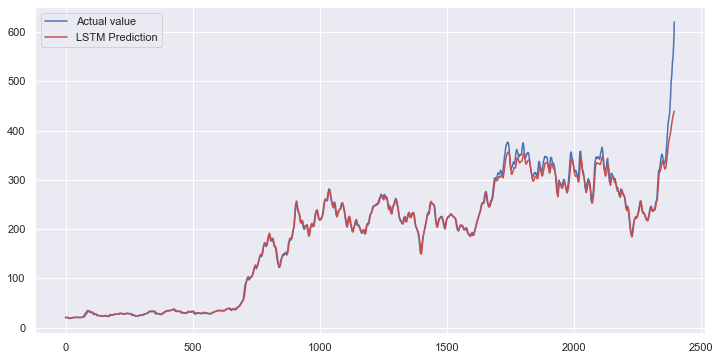

In [11]:
plt.clf()
plt.figure(figsize=(12,6))
my_model1.plot(X_data1, y_data1, scaler1)

<Figure size 864x432 with 0 Axes>

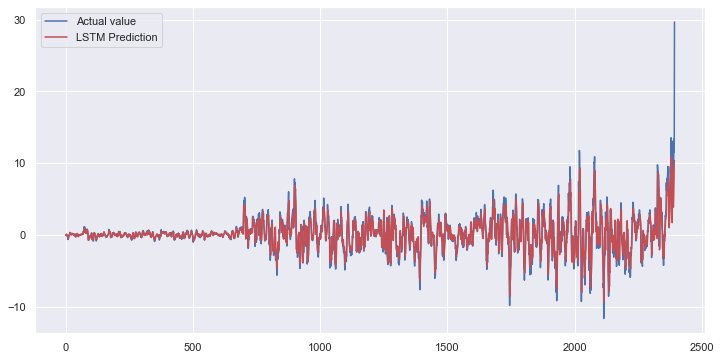

In [12]:
plt.clf()
plt.figure(figsize=(12,6))
my_model2.plot(X_data2, y_data2, scaler2)

Interpretation:

- Undifferenced time series:
The MSE of the predictions produced with our model $(\simeq 105.6)$ is significantly larger than the MSE of the naive prediction $(\simeq 5.95)$. It indicates that our recurrent neural network was not able to learn from the undifferenced time series. It has no forecasting utility. We should not consider the high value of $R^2$ $(\simeq 0.992)$ as an evidence of quality of our model. The $R^2$ is only high because the undifferenced time series has a high autocorrelation. We expect better results on the differenced time series as there is no autocorrelation.

- Differenced time series:
  The MSE of the predictions produced with our model $(\simeq 1.52)$ is lower than the MSE of the naive prediction $(\simeq 5.98)$. Furthermore, it has a high $R^2$ ($\simeq 0.74$) while the naive prediction has a very low $R^2$ $(\simeq -0.01)$. It shows that our neural network is able to forecast the differenced time series. Note that we applied a 7 days moving average to smooth our time series and if we compare our predictions with the raw target values, we get poor results, as expected.

In [13]:
last_day = 2390
print('Second model accuracy with the raw data:')
naive_prediction2 = np.zeros(y_data2.shape[0])
my_model2.get_accuracy(X_data2, y_raw2, naive_prediction2, scaler2, last_day)

Second model accuracy with the raw data:
Mean squared error up to the 2390 day using the naive prediction : 41.86679984864778
Mean squared error up to the 2390 day using the lstm prediction : 45.71458
R2 up to the 2390 day using the naive prediction : -0.0012506598031465366
R2 up to the 2390 day using the lstm prediction : -0.0932708923810095


<Figure size 864x432 with 0 Axes>

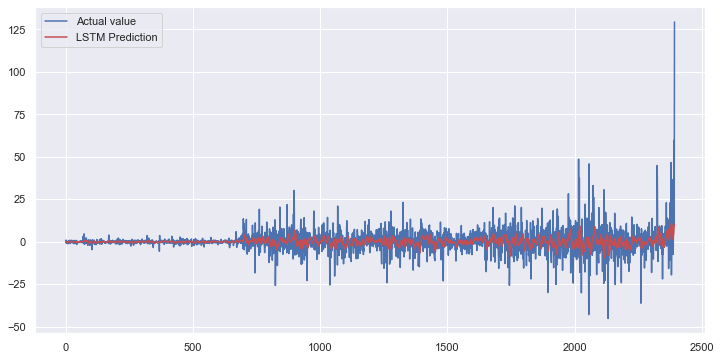

In [14]:
plt.clf()
plt.figure(figsize=(12,6))
my_model2.plot(X_data2, y_raw2, scaler2)

# Forecasting with horizon

Our recurrent neural network (model 2) was able to forecast the adjusted close value of the next day based on the values of the previous 15 days. What if we used the forecasted value as an input to predict the next day and so on ? We compute the MSE and the $R^2$ of our predictions with different horizon:

In [15]:
last_day = y_data2.shape[0]
horizon_1 = 1
horizon_2 = 3
horizon_3 = 7
horizon_4 = 15
naive_prediction_without_horizon2 = np.zeros(y_data2.shape[0])
print('Model accuracy with horizon = 1: \n')
my_model2.get_accuracy_with_horizon(X_data2, y_data2, naive_prediction_without_horizon2, scaler2, last_day, horizon_1)
print('\nModel accuracy with horizon = 3: \n')
my_model2.get_accuracy_with_horizon(X_data2, y_data2, naive_prediction_without_horizon2, scaler2, last_day, horizon_2)
print('\nModel accuracy with horizon = 7: \n')
my_model2.get_accuracy_with_horizon(X_data2, y_data2, naive_prediction_without_horizon2, scaler2, last_day, horizon_3)
print('\nModel accuracy with horizon = 15: \n')
my_model2.get_accuracy_with_horizon(X_data2, y_data2, naive_prediction_without_horizon2, scaler2, last_day, horizon_4)

Model accuracy with horizon = 1: 

Mean squared error up to the 2394 day using the naive prediction : 6.509801450485878
Mean squared error up to the 2394 day using the lstm prediction : 1.696614082781907
R2 up to the 2394 day using the naive prediction : -0.009729195270762547
R2 up to the 2394 day using the lstm prediction : 0.7368397814399463

Model accuracy with horizon = 3: 

Mean squared error up to the 2394 day using the naive prediction : 6.250972203900683
Mean squared error up to the 2394 day using the lstm prediction : 2.704586470235392
R2 up to the 2394 day using the naive prediction : -0.00936178551834188
R2 up to the 2394 day using the lstm prediction : 0.5632829358956275

Model accuracy with horizon = 7: 

Mean squared error up to the 2394 day using the naive prediction : 6.099917099436713
Mean squared error up to the 2394 day using the lstm prediction : 4.182175940330372
R2 up to the 2394 day using the naive prediction : -0.00880209933758036
R2 up to the 2394 day using the

Interpretation: 

We notice that the reccurent neural network (model 2) is able to get the trend for the next 3 days with a $R^2 \simeq 0.56$. With an horizon of 15 however, the lstm predictions ($R^2 = 0.13$) are hardly better than the naive predictions ($R^2 = -0.01$).

We plot the prediction with an horizon of 7 days:

<Figure size 864x432 with 0 Axes>

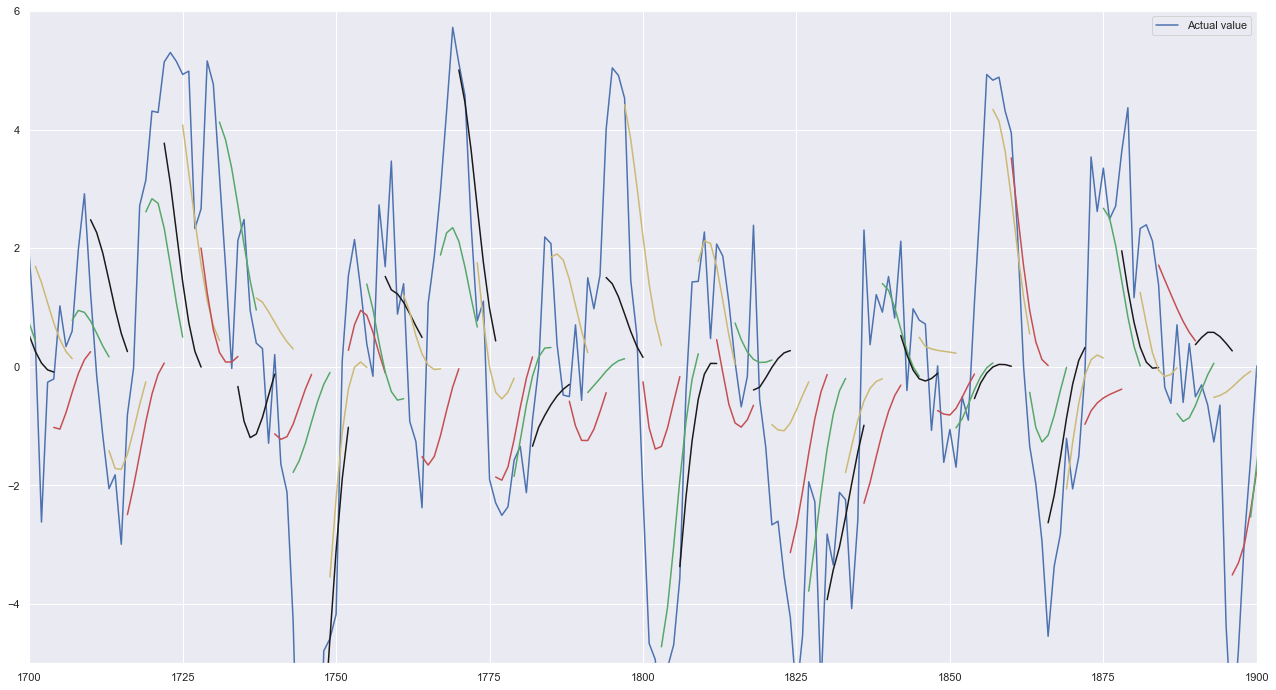

In [16]:
horizon = 7
drawing_jump = 3
plt.clf()
plt.figure(figsize=(22,12))
plt.axis([1700, 1900, -5, 6])
my_model2.plot_with_horizon(X_data2, y_data2, scaler2, horizon, drawing_jump)

# Adding a new feature : the exchange volume

We add the exchange volume data to the features. We also apply a 7 days moving average with a 15 days sliding window on the volume but we do not apply a differencing operation since it varies a lot and has no autocorrelation.

In [17]:
seq_length = 15
average_size = 7
train_proportion = 2/3
scaler3 = MinMaxScaler(feature_range=(-1, 1))

y_raw3, X_data3, y_data3, X_train3, y_train3, X_test3, y_test3 = process_data_custom(tesla_data, seq_length, average_size, train_proportion, scaler3)

In [18]:
my_model3 = LstmNeuralNetwork(input_size = 2, output_size = 2, num_layers = 3, hidden_size = 42, seq_length = seq_length)

In [19]:
num_epochs = 1000
learning_rate = 0.001
criterion = nn.MSELoss()
my_model3._train(num_epochs, learning_rate, criterion, X_train3, y_train3, X_test3, y_test3)

Epoch: 1000, Train loss: 0.00091, Test loss: 0.00391: 100%|██████████| 1001/1001 [05:46<00:00,  2.89it/s]


In [21]:
filepath3 = 'save/model3'
torch.save(my_model3.state_dict(), filepath3)

In [20]:
filepath3 = 'save/model3'
my_model3.load_state_dict(torch.load(filepath3))

<All keys matched successfully>

In [22]:
last_day = y_data3.shape[0]
horizon_1 = 1
horizon_2 = 3
horizon_3 = 7
horizon_4 = 15
naive_prediction_without_horizon3 = np.zeros(last_day)
print('Model accuracy with horizon = 1: \n')
my_model3.get_accuracy_with_horizon(X_data3, y_data3, naive_prediction_without_horizon3, scaler3, last_day, horizon_1)
print('\nModel accuracy with horizon = 3: \n')
my_model3.get_accuracy_with_horizon(X_data3, y_data3, naive_prediction_without_horizon3, scaler3, last_day, horizon_2)
print('\nModel accuracy with horizon = 7: \n')
my_model3.get_accuracy_with_horizon(X_data3, y_data3, naive_prediction_without_horizon3, scaler3, last_day, horizon_3)
print('\nModel accuracy with horizon = 15: \n')
my_model3.get_accuracy_with_horizon(X_data3, y_data3, naive_prediction_without_horizon3, scaler3, last_day, horizon_4)

Model accuracy with horizon = 1: 

Mean squared error up to the 2395 day using the naive prediction : 6.507083391852082
Mean squared error up to the 2395 day using the lstm prediction : 1.7769899486337535
R2 up to the 2395 day using the naive prediction : -0.009725327411431728
R2 up to the 2395 day using the lstm prediction : 0.7242586809417937

Model accuracy with horizon = 3: 

Mean squared error up to the 2395 day using the naive prediction : 6.2483602614294345
Mean squared error up to the 2395 day using the lstm prediction : 2.6999453008106684
R2 up to the 2395 day using the naive prediction : -0.009357352215586978
R2 up to the 2395 day using the lstm prediction : 0.5638520306238348

Model accuracy with horizon = 7: 

Mean squared error up to the 2395 day using the naive prediction : 6.097366090418254
Mean squared error up to the 2395 day using the lstm prediction : 4.136058678596793
R2 up to the 2395 day using the naive prediction : -0.008798004288278705
R2 up to the 2395 day usin

Interpretation : 

By adding the exchange volume to the features, we get similar results. It is surprising as we would expect better results. It indicates that the exchange volume of the tesla stock contains little information about the future.